In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Dense, 
    Flatten, 
    Dropout,
    BatchNormalization,
    Activation
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [74]:
def no_of_subdirs(directory,set_name):
    counts={}
    for item in os.listdir(directory):
        item_path=os.path.join(directory,item)
        if os.path.isdir(item_path):
            counts[item]=len(os.listdir(item_path))
    df=pd.DataFrame(counts,index=[set_name])
    return df

In [75]:
train_dataset=r'C:\Users\ELANGO S\project_data\train'
test_dataset=r'C:\Users\ELANGO S\project_data\test'
train_count=no_of_subdirs(train_dataset,'train')
test_count=no_of_subdirs(test_dataset,'test')
print(train_count)
print(test_count)


       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


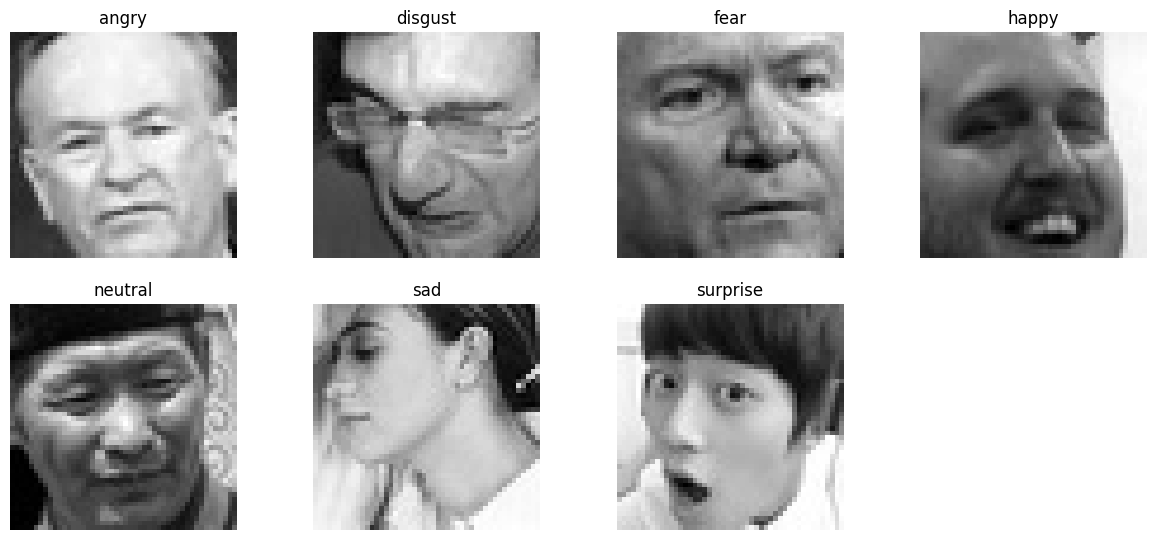

In [76]:
emotions=os.listdir(train_dataset)
plt.figure(figsize=(15,10))
for i,emotion in enumerate(emotions,1):
    folder=os.path.join(train_dataset,emotion)
    img_path=os.path.join(folder,os.listdir(folder)[6])
    img=plt.imread(img_path)
    plt.subplot(3,4,i)
    plt.imshow(img,cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [77]:
# Define data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

#valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [78]:
# Load datasets
def load_dataset(directory, subset, target_size, batch_size, class_mode):
    return train_datagen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        class_mode=class_mode,
        subset=subset,
        batch_size=batch_size
    )

train_dataset = load_dataset(
   r'C:\Users\ELANGO S\project_data\train',
    'training',
    (48, 48),
    64,
    'categorical'
)
# valid_dataset = load_dataset(
#     r'C:\Users\hp\Downloads\dataset_images\test',
#     'validation',
#     (48, 48),
#     64,
#     'categorical'
# )

test_dataset = load_dataset(
    r'C:\Users\ELANGO S\project_data\test',
    None,
    (48, 48),
    64,
    'categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [79]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, BatchNormalization, Dense, Activation
from keras.applications import VGG16

# Load VGG16 model
base_model = VGG16(
    input_shape=(48, 48, 3),
    include_top=False,
    weights="imagenet"
)

# Set base model layers to non-trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [80]:
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dense(7, activation='softmax')
])

In [81]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
model.build(input_shape=(None, 48, 48, 3))

In [83]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,735,879 (56.21 MB)

 Trainable params: 7,099,399 (27.08 MB)

 Non-trainable params: 7,636,480 (29.13 MB)

In [84]:
def f1_score(y_true, y_pred):
    # Calculate True Positives
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    
    # Calculate Possible Positives and Predicted Positives
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    
    # Calculate Precision and Recall
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 Score
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1_val

In [85]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

lrd = ReduceLROnPlateau(
    monitor='val_loss',
    patience=20,
    verbose=1,
    factor=0.50,
    min_lr=1e-10
)

mcp = ModelCheckpoint('model.keras')

es = EarlyStopping(
    verbose=1,
    patience=20
)

In [86]:
# Compile and train the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    verbose=1,
    callbacks=[lrd, mcp, es]
)

Epoch 1/30


C:\Users\hp\opencv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



449/449 ━━━━━━━━━━━━━━━━━━━━ 652s 1s/step - accuracy: 0.8543 - auc: 0.5898 - f1_score: 0.0420 - loss: 1.9591 - precision: 0.3420 - recall: 0.0226 - val_accuracy: 0.8158 - val_auc: 0.6731 - val_f1_score: 0.2606 - val_loss: 2.2603 - val_precision: 0.3059 - val_recall: 0.2279 - learning_rate: 0.0010
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 401s 890ms/step - accuracy: 0.8606 - auc: 0.7175 - f1_score: 0.1250 - loss: 1.6975 - precision: 0.6020 - recall: 0.0702 - val_accuracy: 0.8639 - val_auc: 0.7458 - val_f1_score: 0.1538 - val_loss: 1.6354 - val_precision: 0.6809 - val_recall: 0.0886 - learning_rate: 0.0010
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 394s 877ms/step - accuracy: 0.8630 - auc: 0.7408 - f1_score: 0.1662 - loss: 1.6491 - precision: 0.6356 - recall: 0.0962 - val_accuracy: 0.8672 - val_auc: 0.7516 - val_f1_score: 0.1959 - val_loss: 1.6120 - val_precision: 0.7222 - val_recall: 0.1141 - learning_rate: 0.0010
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 404s 899ms/step - accuracy: 0.8641 - a

In [87]:
print("\nEvaluating the model on the test dataset...")
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1_score = model.evaluate(test_dataset)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")


Evaluating the model on the test dataset...
113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 630ms/step - accuracy: 0.8788 - auc: 0.8270 - f1_score: 0.3642 - loss: 1.4001 - precision: 0.7220 - recall: 0.2459

Test Loss: 1.4013
Test Accuracy: 0.8790
Test Precision: 0.7274
Test Recall: 0.2446
Test AUC: 0.8264
Test F1 Score: 0.3635


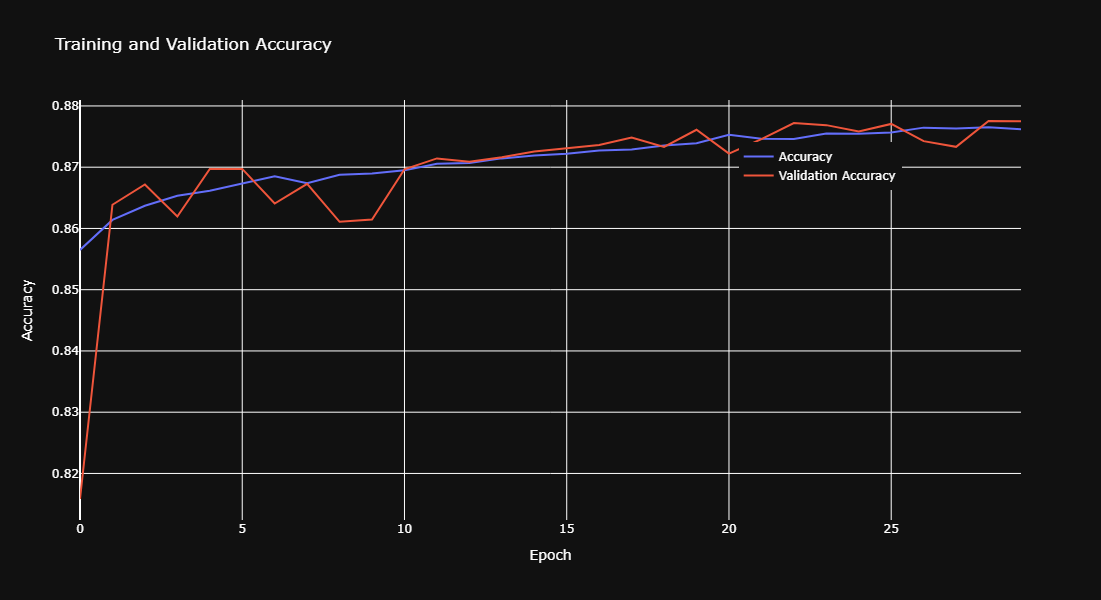

In [89]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['accuracy'],
                         name='Accuracy'))
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_accuracy'],
                         name='Validation Accuracy'))
fig.update_layout(title='Training and Validation Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy',
                  legend=dict(x=0.7, y=0.9),
                  width=800,
                  height=600,
                  plot_bgcolor='rgb(17, 17, 17)',
                  paper_bgcolor='rgb(17, 17, 17)',
                  font=dict(color='white'))
fig.show()

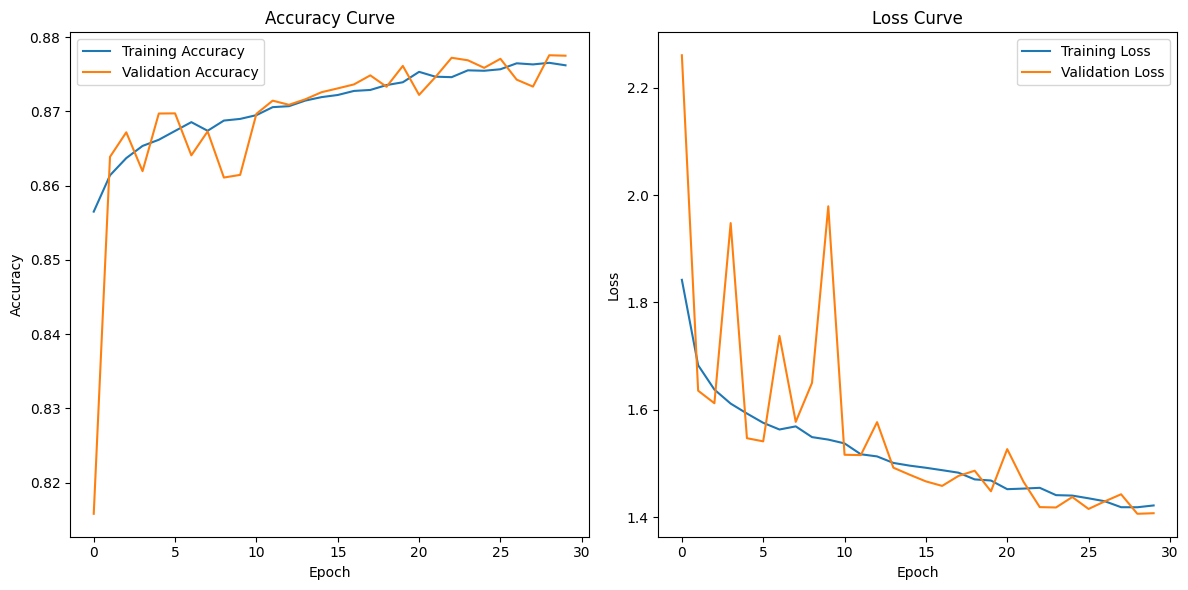

In [90]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

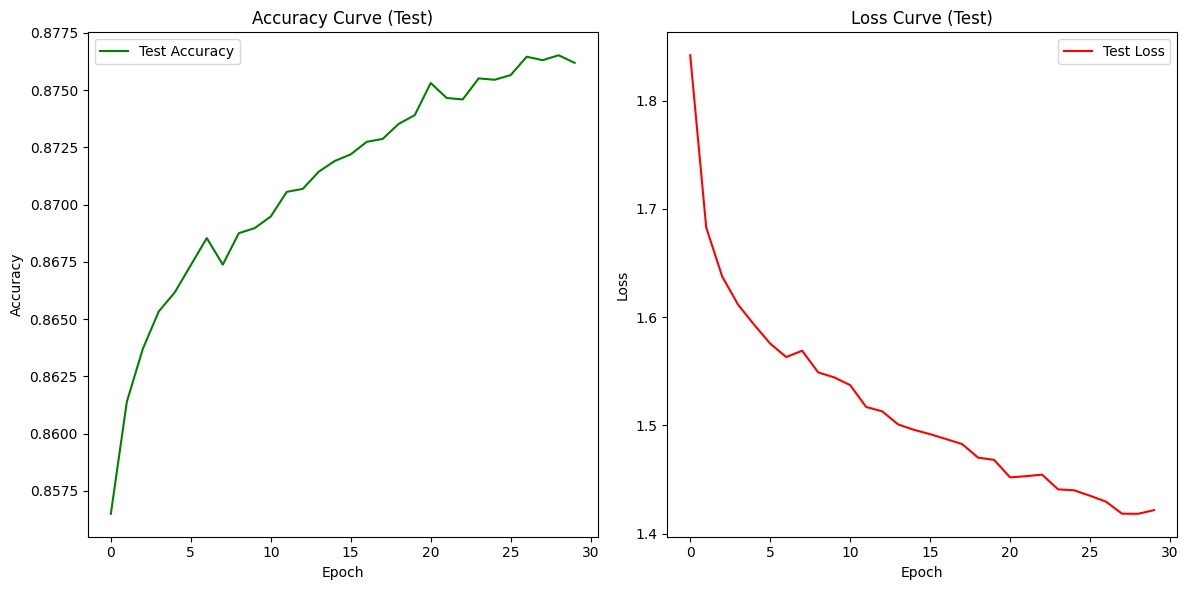

In [91]:
plt.figure(figsize=(12, 6))

# Plot Test Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Test Accuracy', color='green')
plt.title('Accuracy Curve (Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Test Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Test Loss', color='red')
plt.title('Loss Curve (Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [92]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()

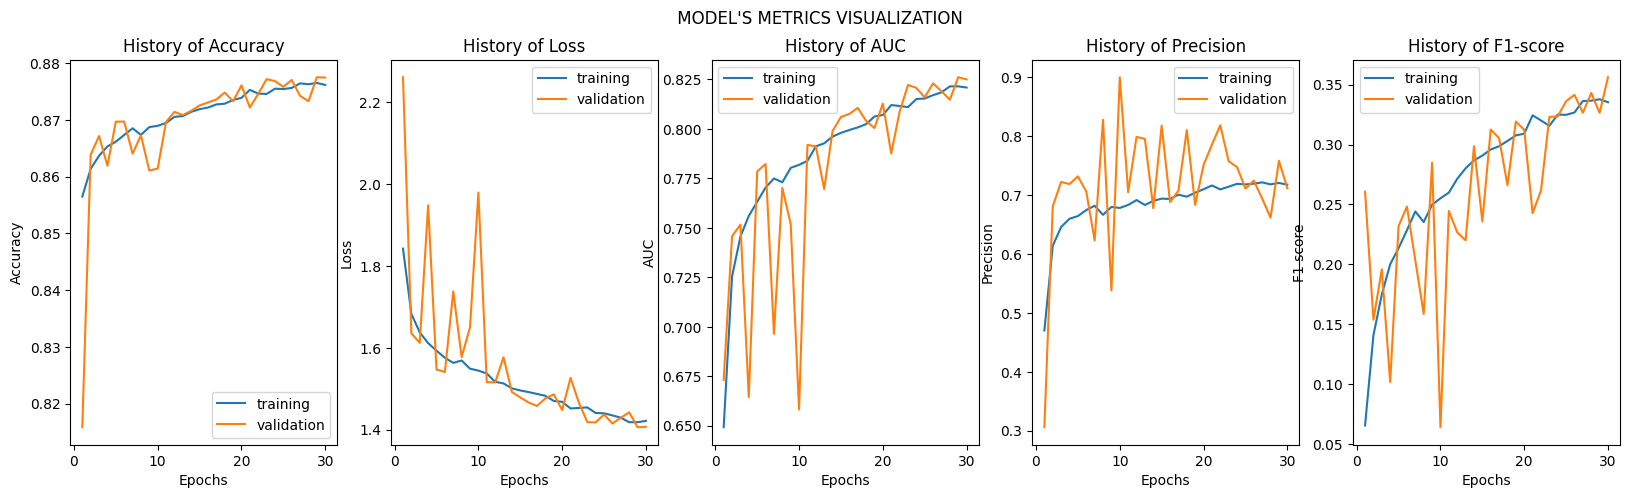

In [93]:
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [94]:

Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']



In [95]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Directory where your test data is located
test_directory = r'C:\Users\ELANGO S\project_data\test'
# Define the image data generator for test data
test_preprocessor = ImageDataGenerator(
    rescale=1.0 / 255
)

# Create the test data generator
test_generator = test_preprocessor.flow_from_directory(
    test_directory,
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=True,
    batch_size=64
)


Found 7178 images belonging to 7 classes.


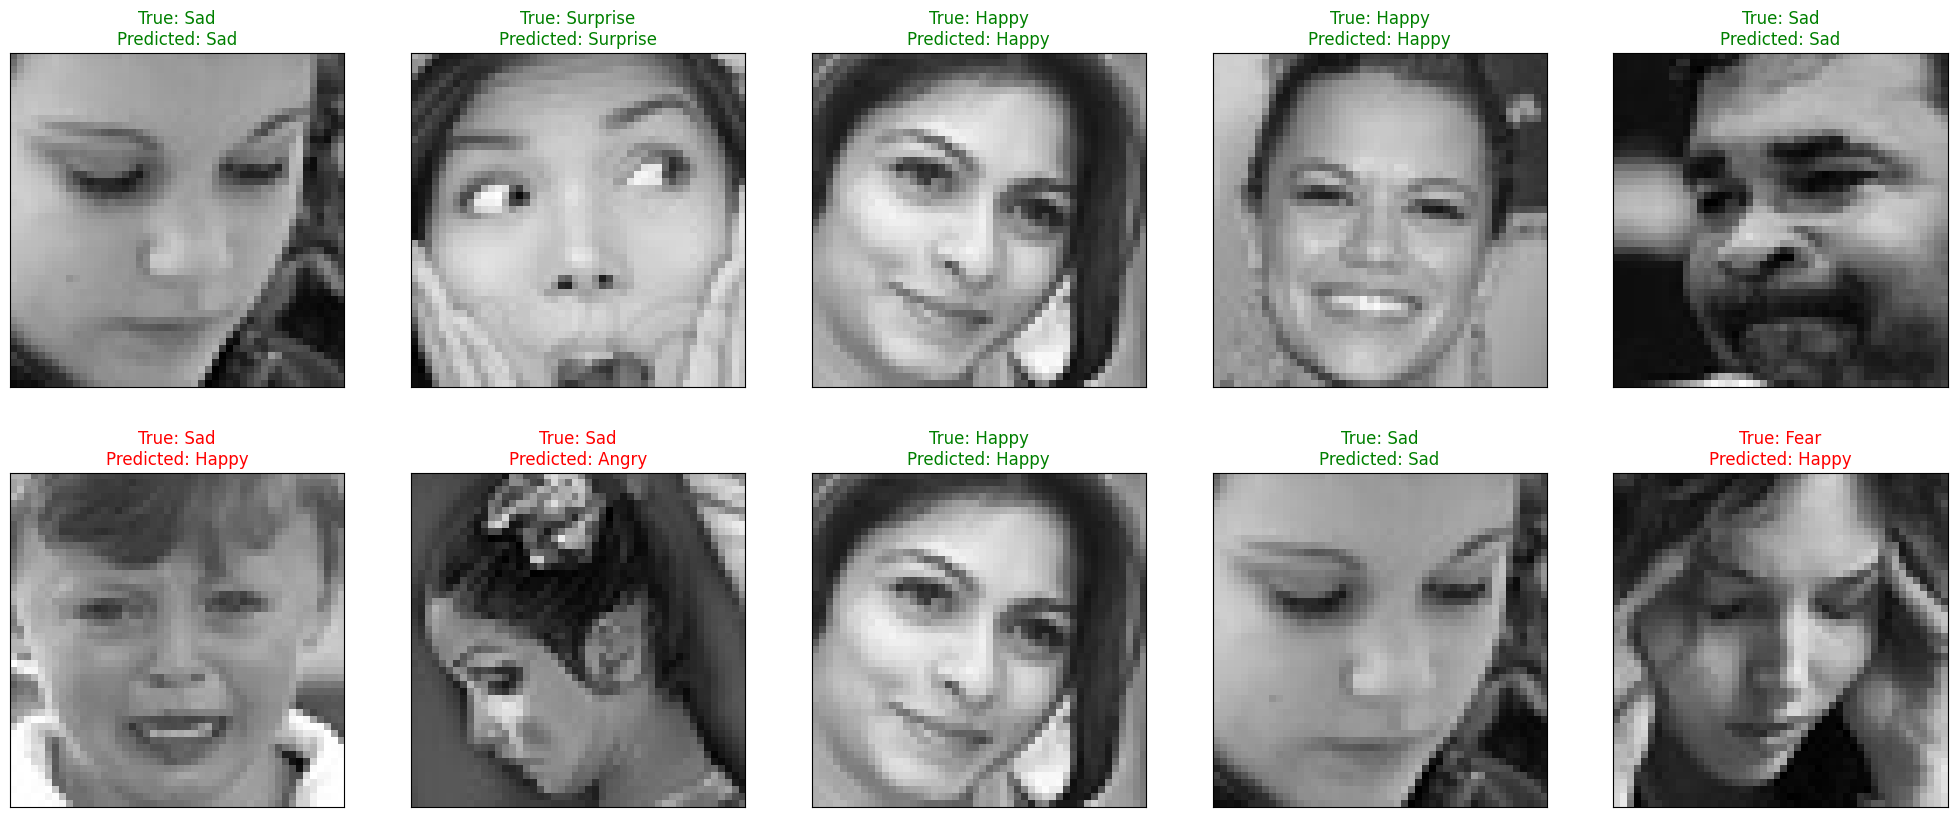

<Figure size 640x480 with 0 Axes>

In [98]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, 64 - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))
    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 627ms/step


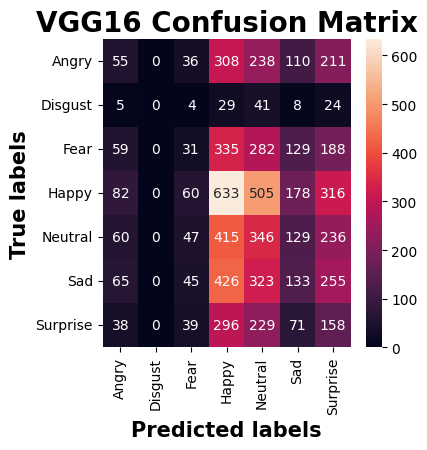

In [99]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming Model_Prediction is the predictions made by your model
# Assuming test_generator.labels are the true labels of your test data

# Convert test_generator.labels to a flat array
true_labels = test_generator.classes

# Convert Model_Prediction to a flat array
predicted_labels = model.predict(test_generator)
predicted_labels = predicted_labels.argmax(axis=1)  # Assuming it's a softmax output

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']  # Adjust if needed
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, xticklabels=emotion_labels, yticklabels=emotion_labels)
ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('VGG16 Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()



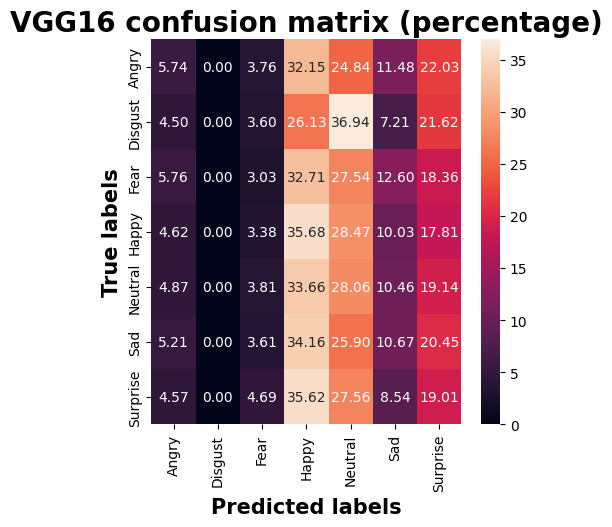

In [101]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(5,5))


sns.heatmap(cm_percent, annot=True, fmt='.2f', ax=ax, xticklabels=emotion_labels, yticklabels=emotion_labels)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('VGG16 confusion matrix (percentage)', fontsize=20, fontweight='bold')

plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 83s 737ms/step


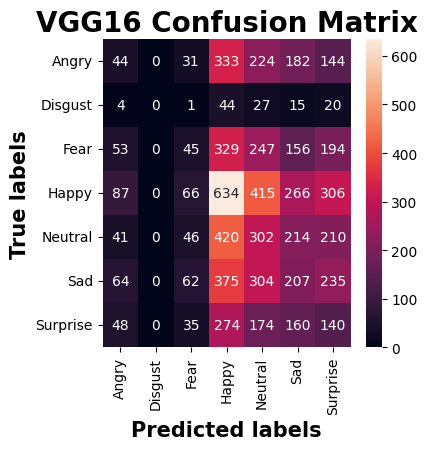

In [102]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming Model_Prediction is the predictions made by your model
# Assuming test_generator.labels are the true labels of your test data

# Convert test_generator.labels to a flat array
true_labels = test_generator.classes

# Convert Model_Prediction to a flat array
predicted_labels = model.predict(test_dataset)
predicted_labels = predicted_labels.argmax(axis=1)  # Assuming it's a softmax output

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']  # Adjust if needed
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, xticklabels=emotion_labels, yticklabels=emotion_labels)
ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('VGG16 Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()
